In [1]:
__author__ = "Yaassh Rao"
__email__ = "yaassh_rao@outlook.com"

# Importing packages

In [2]:
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.linear_model import Ridge

# Training Set

The training set has about 1,500,000 observations

In [3]:
## Having a look at the training set
mercari_train = pd.read_csv('/Users/yaasshrao/Desktop/Projects/Mercari NLP/mercari-price-suggestion-challenge/train.tsv',delimiter='\t',engine='python')
mercari_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
print("The size of the training data is: " + str(mercari_train.shape))
print(mercari_train.dtypes)

The size of the training data is: (1482535, 8)
train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object


## _Summary Statistics_

 Most items are priced at $10
 There are around 33,000 items without description
 Majority of the items are in the women's brand

In [5]:
mercari_train.astype('object').describe().transpose()
# Using .describe() on the categorical variables, rather than numerical variables.

,count,unique,top,freq
train_id,1482535,1482535,1482534,1
name,1482535,1225273,Bundle,2232
item_condition_id,1482535,5,1,640549
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177
brand_name,849853,4809,PINK,54088
price,1.48254e+06,828,10,99416
shipping,1482535,2,0,819435
item_description,1482531,1281426,No description yet,82489


# Test Set

The test set has about 700,000 observations.

In [6]:
# Observe testing set
mercari_test = pd.read_csv('/Users/yaasshrao/Desktop/Projects/Mercari NLP/mercari-price-suggestion-challenge/test.tsv', sep = '\t',engine = 'python')
mercari_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [7]:
mercari_test.shape

(693359, 7)

# Data Cleaning
Imputing the missing values

In [8]:
# Determining the number of missing values in the training set: 
mercari_train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

### Observation:
'brand_name', 'category_name' & 'item_description' have missing values, with 'brand_name' possessing the maximum quantity of missing values.

In [9]:
# Creating a function to impute missing values:
def fill_missing_value(data):
    data['category_name'].fillna(value = 'Other', inplace=True)
    data['brand_name'].fillna(value = 'uknown', inplace=True)
    data['item_description'].fillna(value = 'No description yet', inplace=True)
    
    return data

In [10]:
mercari_train = fill_missing_value(mercari_train)
mercari_train.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

# Exploratory Data Analysis

## 1. Examining target variable (Price) and determining which features correlate the most with the target variable (Price)

In [11]:
mercari_train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

### Observation:
Mean price in the dataset is 26 Dollars.
Median price in the dataset is 17 Dollars.
Maximum price in the dataset is 2009 Dollars.

Text(0.5, 1.0, 'Price Distribution')

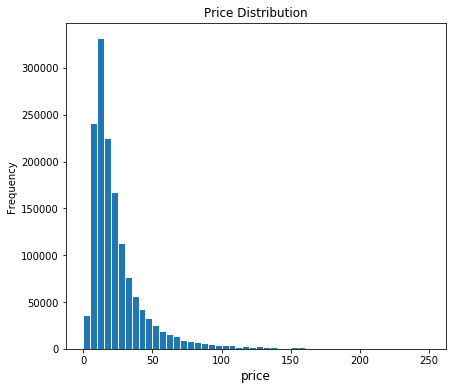

In [12]:
# Plotting Price Distribution
plt.subplot(1, 2, 1)
(mercari_train['price']).plot.hist(bins=50, figsize=(15, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

### Observation:
The distribution is heavily right skewed. The bulk of our prices lie between $5-$25. Thus, we will normalize our distribution, to follow a standard normal distribution.  

Additionally, these products are already sold, yet some products are showing a price of $0. 

Text(0.5, 1.0, 'Log Price Distribution')

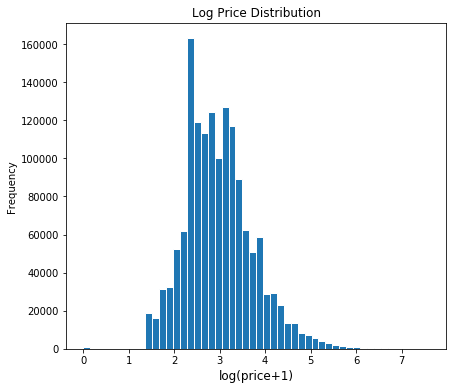

In [13]:
# Plotting Log Price Distribution
plt.subplot(1, 2, 2)
np.log(mercari_train['price']+1).plot.hist(bins=50, figsize=(15,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12)

## 2. Removing Items with price equal to zero dollars

In [14]:
mercari_train[mercari_train.price==0].shape

(874, 8)

In [15]:
mercari_train[mercari_train.price==0]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,uknown,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,uknown,0.0,0,"Very simple but cute, a little form fitting as..."
3576,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,uknown,0.0,1,1 left!
3761,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,uknown,0.0,1,5 pair gap jean excellent used condition 3 chi...
5237,5237,Nursing Bra,3,Women/Underwear/Bras,Motherhood Maternity,0.0,0,Used a few times but was not able to nurse
6175,6175,"Multi Listing Bundled Package, Thanks",2,Electronics/Media/DVD,uknown,0.0,1,1)Large Collection of Full Length Strawberry S...
7116,7116,Nike Dri-Fit High Power Speed Tights,1,"Women/Athletic Apparel/Pants, Tights, Leggings",Nike,0.0,1,"Bought at Nike store in New York, Brand New, N..."
7622,7622,Hands free earpiece,1,Electronics/Cell Phones & Accessories/Headsets,uknown,0.0,0,Wireless Bluetooth hands free used with Samsun...
10812,10812,Vampire candy bowl,1,Home/Seasonal Décor/Halloween,uknown,0.0,0,New good condition for halloween


### Observation: There are only 874 rows of data with price equals zero dollars, which is negligible as compared to the overall training data. Hence, we will be removing these rows.

In [16]:
# Retaining only those items with price not equal to zero
mercari_train = mercari_train[mercari_train.price!=0]
mercari_train.shape

(1481661, 8)

## 3. Exploring shipping information
## Do items with a shipping cost associated with it, possess a higher price in general?

In [17]:
# Checking which items have a shipping cost associated with them; 1 = Has a shipping cost, 0 = No shipping cost
mercari_train['shipping'].value_counts() / len(mercari_train)

0    0.552674
1    0.447326
Name: shipping, dtype: float64

### Observation:
Shipping does increase the price value and confirms our hypothesis.

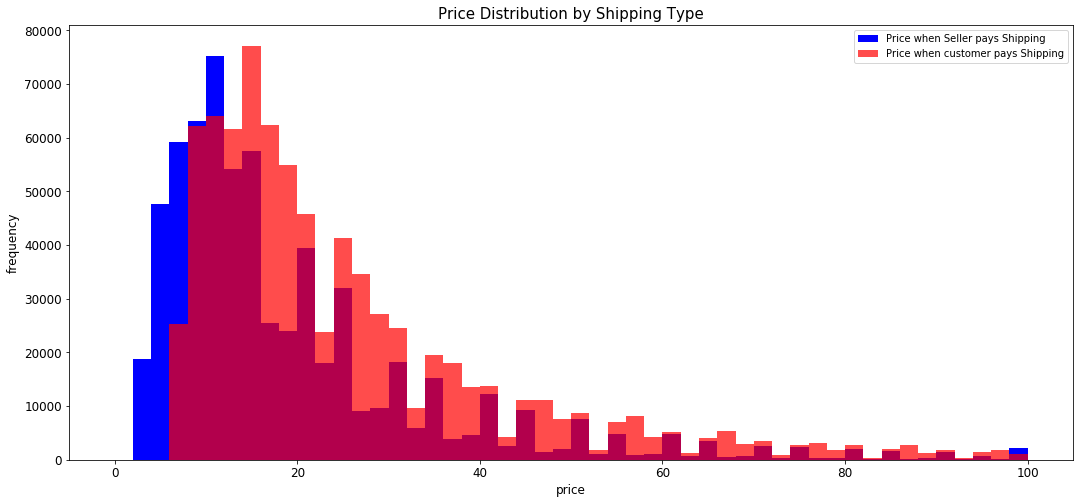

The average price is $ 22.58 if seller pays shipping
The average price is $ 30.13 if customer pays shipping


In [18]:
shipping_fee_by_customer = mercari_train.loc[mercari_train['shipping'] == 0, 'price']
shipping_fee_by_seller = mercari_train.loc[mercari_train['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))

ax.hist(shipping_fee_by_seller, color='blue', alpha=1.0, bins=50, range = [0, 100],label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_customer, color='red', alpha=0.7, bins=50, range = [0, 100],label='Price when customer pays Shipping')

plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

print('The average price is $ {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is $ {}'.format(round(shipping_fee_by_customer.mean(), 2)), 'if customer pays shipping')

### Observation:
The seller pays for shipping for mostly those products which have a cheaper price.

## 4. Top Categories of products

In [19]:
top_10_category = mercari_train['category_name'].value_counts()[:10].reset_index()
top_10_category

,index,category_name
0,"Women/Athletic Apparel/Pants, Tights, Leggings",60152
1,Women/Tops & Blouses/T-Shirts,46349
2,Beauty/Makeup/Face,34320
3,Beauty/Makeup/Lips,29901
4,Electronics/Video Games & Consoles/Games,26547
5,Beauty/Makeup/Eyes,25200
6,"Electronics/Cell Phones & Accessories/Cases, C...",24668
7,Women/Underwear/Bras,21254
8,"Women/Tops & Blouses/Tank, Cami",20270
9,Women/Tops & Blouses/Blouse,20269


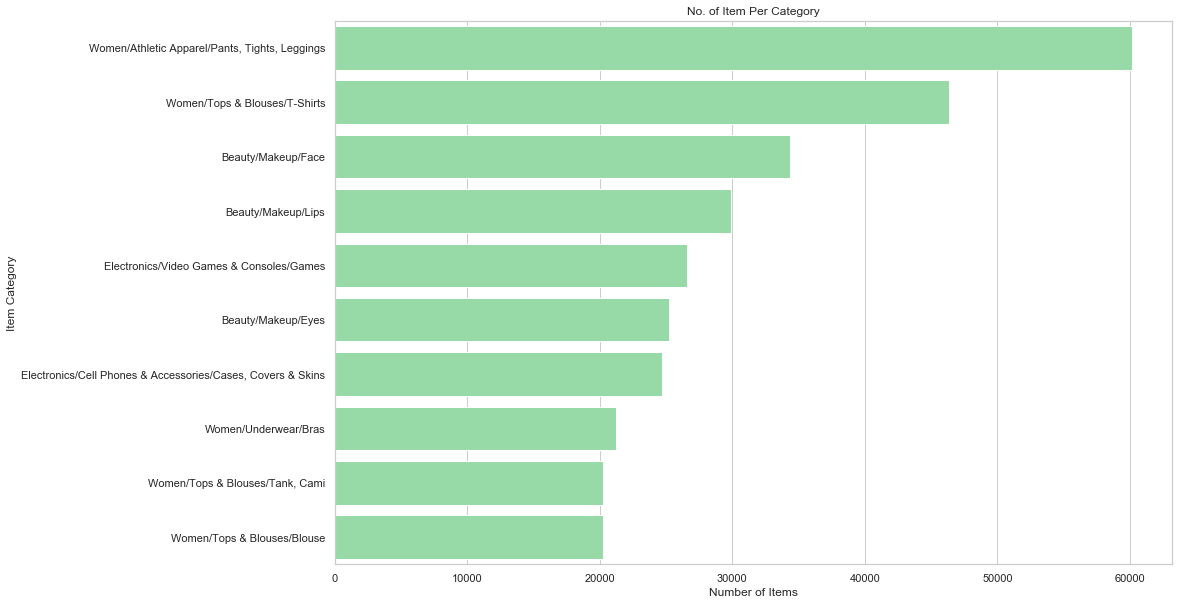

In [20]:
sns.set(style="whitegrid")

# Initializing the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Plotting the total items per category
sns.set_color_codes("pastel")
sns.barplot(x="category_name", y='index', data=top_10_category,
            label="# Items", color="g")

# Adding a legend and informative axis label
ax.set( ylabel="Item Category", title='No. of Item Per Category',
       xlabel="Number of Items")

plt.show()

### Observation: The top products sold on Mercari cater to women, as most of the products are women's products. This is based on logic. This would be beneficial to know from a targeted marketing standpoint. In order to prove this point, I have created two new features, to further delve into the categorization of products. 

# Feature Engineering

## Creating TWO new features named sub1 & sub2. 
## This follows the format of Root_category/Category/Sub_Category. 

In [21]:
# Feature Engineering (1): Creating new Category Features
def transform_category_name(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return 'Other','Other','Other'

In [22]:
mercari_train['category_main'], mercari_train['category_sub1'], mercari_train['category_sub2'] = zip(*mercari_train['category_name'].apply(transform_category_name))

cat_train = mercari_train[['category_main','category_sub1','category_sub2', 'price']]

cat_train.head()

,category_main,category_sub1,category_sub2,price
0,Men,Tops,T-shirts,10.0
1,Electronics,Computers & Tablets,Components & Parts,52.0
2,Women,Tops & Blouses,Blouse,10.0
3,Home,Home Décor,Home Décor Accents,35.0
4,Women,Jewelry,Necklaces,44.0


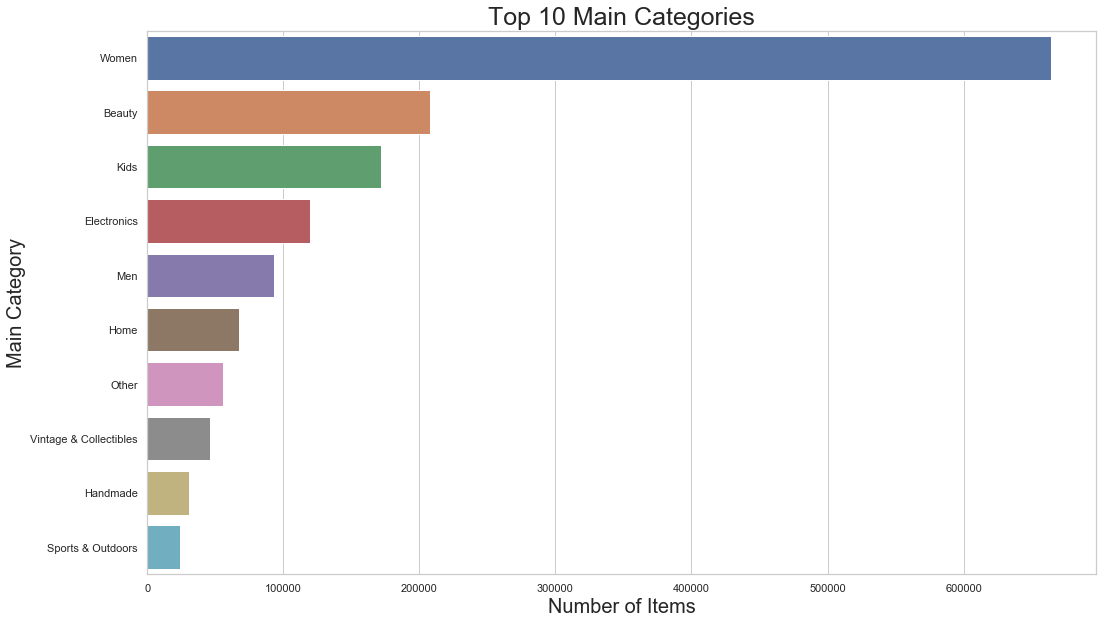

Women                     0.448139
Beauty                    0.140197
Kids                      0.115786
Electronics               0.080705
Men                       0.062964
Home                      0.045780
Other                     0.037814
Vintage & Collectibles    0.031397
Handmade                  0.020810
Sports & Outdoors         0.016408
Name: category_main, dtype: float64

In [23]:
# Proportion of top main categories
plt.figure(figsize=(17,10))
sns.countplot(y = mercari_train['category_main'], order = mercari_train['category_main'].value_counts().index, orient = 'v')
plt.title('Top 10 Main Categories', fontsize = 25)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Number of Items', fontsize =20)
plt.show()

mercari_train['category_main'].value_counts()/len(mercari_train)

### Observation: Women occupy 44% of the market share. 

## Analysis By Brands

In [24]:
# Amount of unique brand names
mercari_train['brand_name'].nunique()

4808

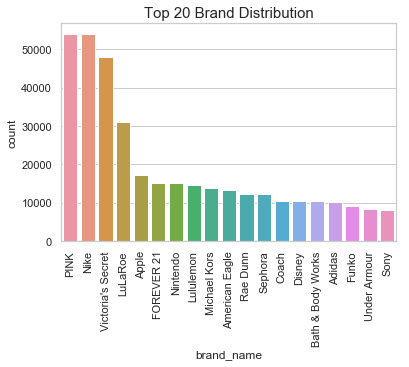

In [25]:
# Top 20 Brand Distribution by quantity
b20 = mercari_train['brand_name'].value_counts()[1:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", data=b20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()

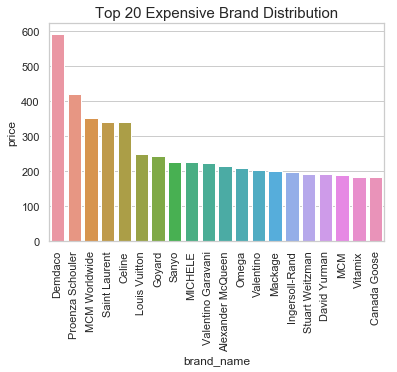

In [26]:
# Top 20 Brand Distribution by Price
top_20_exp_brand = pd.DataFrame(mercari_train.groupby(['brand_name'],as_index=True).std().price.sort_values(ascending=False)[0:20]).reset_index()
ax = sns.barplot(x="brand_name", y="price", data=top_20_exp_brand)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Expensive Brand Distribution', fontsize=15)
plt.show()

## Length of Description v/s Price

In [27]:
mercari_train.item_description = mercari_train.item_description.astype(str)

descr = mercari_train[['name','item_description', 'price']]
descr['count'] = descr['item_description'].apply(lambda x : len(str(x)))
descr.head()

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,name,item_description,price,count
0,MLB Cincinnati Reds T Shirt Size XL,No description yet,10.0,18
1,Razer BlackWidow Chroma Keyboard,This keyboard is in great condition and works ...,52.0,188
2,AVA-VIV Blouse,Adorable top with a hint of lace and a key hol...,10.0,124
3,Leather Horse Statues,New with tags. Leather horses. Retail for [rm]...,35.0,173
4,24K GOLD plated rose,Complete with certificate of authenticity,44.0,41


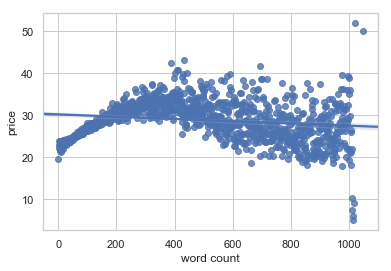

In [28]:
df = descr.groupby('count')['price'].mean().reset_index()
sns.regplot(x=df["count"], y=(df["price"]))
plt.xlabel("word count")
plt.show()

# Text Processing

### Punctuations

In [29]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [30]:
# Creating a list of punctuation replacements

punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))
    
punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

### List of stop words

In [31]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/yaasshrao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
# Examine list of stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Normalizing the words by:
Removing Punctuations
Removing Stop Words
Lowercasing the Words
Stemming the Words

In [33]:
# Function to normalize the words
import string

# Create a function to remove punctuations
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Create a function to remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Create a function to lowercase the words
def to_lower(x):
    return x.lower()

# Stemming the words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
mercari_train['item_description'] = mercari_train['item_description'].apply(porter.stem)

mercari_train['item_description'] = mercari_train['item_description'].apply(remove_punctuation)
mercari_train['item_description'] = mercari_train['item_description'].apply(remove_stop_words)
mercari_train['item_description'] = mercari_train['item_description'].apply(to_lower)

mercari_train['name'] = mercari_train['name'].apply(remove_punctuation)
mercari_train['name'] = mercari_train['name'].apply(remove_stop_words)
mercari_train['name'] = mercari_train['name'].apply(to_lower)

# Feature Extraction with text

### Since we're working with Text Features, we're going to do a lot of vectorization:
### A) Tokenization: split each text into words (bag of words model)
### B) Stemming: removing word inflections (getting the root word)
### C) Vectorization: reducing text into a vector with different types of frequencies for each word (Count Values or TF-IDF Values)

### A) Bag of words model

In [34]:
# Examining the normalize item description
mercari_train['item_description'][115:125]

115                never worn brown leather strap wedges
116                  boys lebron soldier 9s great condit
117                                      description yet
118    bombshell  eau sexy bombshell used bit lots pr...
119    victorias secret pink black zip hoodie gently ...
120    sweater like long sleeved shirt glows dark pur...
121    tens 3000 back pain would great new without bo...
122         sizes info clothes found individual postings
123    white xl dress built bra strapless ties around...
124    miss style name skinny size 26 inseam 32 miss ...
Name: item_description, dtype: object

In [35]:
from nltk.tokenize import word_tokenize

text1 = mercari_train['item_description'][120]
tokens = word_tokenize(text1)
print(tokens)

['sweater', 'like', 'long', 'sleeved', 'shirt', 'glows', 'dark', 'purchased', 'another', 'seller', 'didnt', 'fit', 'says', 'size', 'would', 'put']


### C) Count Vectorizer

In [36]:
# CountVectorizer - name & categories
cv = CountVectorizer(min_df=10)
X_name = cv.fit_transform(mercari_train['name'])
X_category_main = cv.fit_transform(mercari_train['category_main'])
X_category_sub1 = cv.fit_transform(mercari_train['category_sub1'])
X_category_sub2 = cv.fit_transform(mercari_train['category_sub2'])

In [37]:
print("Item Name Shape: " + str(X_name.shape))
print("Category Main Shape: " + str(X_category_main.shape))
print("Category Sub1 Shape: " + str(X_category_sub1.shape))
print("Category Sub2 Shape: " + str(X_category_sub2.shape))

Item Name Shape: (1481661, 18310)
Category Main Shape: (1481661, 12)
Category Sub1 Shape: (1481661, 141)
Category Sub2 Shape: (1481661, 805)


### Label Binarizer

In [38]:
# Applying LabelBinarizer to "brand_name"
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(mercari_train['brand_name'])

In [39]:
print("Item Brand Shape: " + str(X_brand.shape))

Item Brand Shape: (1481661, 4808)


### Get Dummies

In [40]:
# Applying get_dummies to "item_condition_id" and "shipping" and then convert into a CSR Matrix
X_dummies = csr_matrix(pd.get_dummies(mercari_train[['item_condition_id', 'shipping']], sparse=True).values)

### TF-IDF: Term Frequency - Inverse Document Frequency

Important Parameters
. ngram_range
. stop_words
. lowercase
. max_df - max threshold that will ignore a term that has a document frequency higher than the threshold
. min_df - min threshold that will ignore a term that has a document frequency lower than the threshold
. max_features - gets the assigned amount of features with highest amount of term frequencies (scores)

In [41]:
# Perform a TFIDF Transformation of the item description with the top 55000 features and has an n-gram range of 1-2
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(mercari_train['item_description'])

In [42]:
print("Item Description Shape: " + str(X_description.shape))

Item Description Shape: (1481661, 55000)


### Observing TF-IDF weights

In [43]:
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(tv.get_feature_names(), tv.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

# Lowest TFIDF Scores (Less importance of a word)
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)


,tfidf
new,2.187014
size,2.347269
brand,2.758962
brand new,2.883607
condition,2.925553
free,2.930798
worn,3.111408
used,3.220149
shipping,3.225996
great,3.347702


In [44]:
# Highest TFIDF Scores (More importance terms for the model to learn)
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
beats beats,13.011450
evod pro,12.723768
shipped containers,12.436086
pairrm pairrm,12.375462
3b,12.375462
ijust,12.264236
wide weft,12.212943
guards shade,12.164153
3ml teeth,12.164153
comment rm,12.117633


### Observation: The higher TFIDF scores have bi-grams, hence providing more description.

## Combining all features into a single merge using a Compressed Sparse Row (CSR) matrix.

In [45]:
# Combine everything together
sparse_merge = hstack((X_dummies, X_description, X_brand, X_name, X_category_main, X_category_sub1, X_category_sub2)).tocsr()

# Getting 10% of the training data

In [46]:
reduced_X_train = mercari_train.sample(frac=0.1).reset_index(drop=True)
reduced_y_train = np.log1p(reduced_X_train['price'])

In [47]:
reduced_X_train.shape

(148166, 11)

## Fast Data Cleaning

In [48]:
reduced_X_train['category_name'] = reduced_X_train['category_name'].fillna('Other').astype(str)
reduced_X_train['brand_name'] = reduced_X_train['brand_name'].fillna('missing').astype(str)
reduced_X_train['shipping'] = reduced_X_train['shipping'].astype(str)
reduced_X_train['item_condition_id'] = reduced_X_train['item_condition_id'].astype(str)
reduced_X_train['item_description'] = reduced_X_train['item_description'].fillna('None')

In [49]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

# Initialize CountVectorizer
cvectorizer = CountVectorizer(max_features=20000,
                              stop_words='english', 
                              lowercase=True)

# Fit it to our dataset
cvz = cvectorizer.fit_transform(reduced_X_train['item_description'])

# Initialize LDA Model with 10 Topics
lda_model = LatentDirichletAllocation(n_topics=10,
                                      random_state=42)

# Fit it to our CountVectorizer Transformation
X_topics = lda_model.fit_transform(cvz)

# Define variables
n_top_words = 10
topic_summaries = []

# Get the topic words
topic_word = lda_model.components_
# Get the vocabulary from the text features
vocab = cvectorizer.get_feature_names()

# Display the Topic Models
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

/anaconda2/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0: color | new | used | brush | lip | matte | makeup | palette | brand | lipstick
Topic 1: rm | iphone | case | phone | plus | shipping | screen | free | quality | available
Topic 2: condition | great | items | used | good | item | questions | box | comes | shipping
Topic 3: oz | skin | new | body | used | oil | cream | bottle | fl | bath
Topic 4: size | black | pink | new | blue | dress | leggings | white | color | lularoe
Topic 5: size | condition | worn | great | good | small | used | medium | excellent | like
Topic 6: description | bag | secret | pink | leather | victorias | new | pocket | used | inside
Topic 7: new | free | brand | shipping | price | rm | bundle | firm | ship | items
Topic 8: size | worn | new | fit | bought | brand | like | waist | jeans | cute
Topic 9: gold | silver | ring | necklace | size | bracelet | rm | jewelry | earrings | chain
CPU times: user 8min 48s, sys: 4.54 s, total: 8min 52s
Wall time: 9min 12s


## Analyzing Item Description Using Eli5  

In [50]:
# Definte RMSLE Cross Validation Function
def rmsle_cv(model):
    kf = KFold(shuffle=True, random_state=42).get_n_splits(reduced_X_train['item_description'])
    rmse= np.sqrt(-cross_val_score(model, reduced_X_train['item_description'], reduced_y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse.mean())

## Baseline Model with Count Vectorizer

In [51]:
from sklearn.linear_model import Ridge

vec = CountVectorizer()
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

cv_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(cv_rmsle))

/anaconda2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6665176721718861


In [52]:
import eli5
eli5.show_weights(pipe, vec=vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+1.043,tria
+1.012,bergdorf
+0.964,tieks
+0.943,neverfull
+0.938,celine
+0.908,macassar
+0.885,powerbeats
+0.877,512gb
+0.870,lea
+0.836,lambskin


In [53]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1297], vec=vec)

## Baseline Model with Count Vectorizer + Stop Words

In [54]:
vec = CountVectorizer(stop_words='english')
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

cv_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(cv_sw_rmsle))

/anaconda2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6660502226779242


In [55]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1297], vec=vec)

## Baseline Model with TF-IDF

In [56]:
vec = TfidfVectorizer()
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

tfidf_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_rmsle))

/anaconda2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6196362785858703


In [57]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1297], vec=vec)

## Baseline Model with TF-IDF + Stop Words

In [58]:
vec = TfidfVectorizer(stop_words='english')
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

tfidf_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_rmsle))

/anaconda2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6203064689644567


In [59]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1297], vec=vec)

## Baseline Model with TF-IDF + Stop Words + N-grams

In [60]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

tfidf_sw_ng_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_ng_rmsle))

/anaconda2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6100320923269485


In [61]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1297], vec=vec)

## Summary

In [62]:
print ("RMSLE Score: " + str(cv_rmsle) + " | CountVectorizer")
print ("RMSLE Score: " + str(cv_sw_rmsle) + " | CountVectorizer | Stop Words")
print ("RMSLE Score: " + str(tfidf_rmsle) + " | TF-IDF")
print ("RMSLE Score: " + str(tfidf_sw_rmsle) + " | TF-IDF | Stop Words")
print ("RMSLE Score: " + str(tfidf_sw_ng_rmsle) + " | TF-IDF | Stop Words | N-Grams")

RMSLE Score: 0.6665176721718861 | CountVectorizer
RMSLE Score: 0.6660502226779242 | CountVectorizer | Stop Words
RMSLE Score: 0.6196362785858703 | TF-IDF
RMSLE Score: 0.6203064689644567 | TF-IDF | Stop Words
RMSLE Score: 0.6100320923269485 | TF-IDF | Stop Words | N-Grams


# Text Feature Transformations

### Transformer ---> Pipeline ---> Connecting Multiple Pipelines

In [63]:
from sklearn.pipeline import FeatureUnion

default_preprocessor = CountVectorizer().build_preprocessor()

def build_preprocessor(field):
    field_idx = list(reduced_X_train.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])

vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        ngram_range=(1, 2),
        max_features=50000,
        preprocessor=build_preprocessor('name'))),
    ('category_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_name'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name'))),
    ('shipping', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('shipping'))),
    ('item_condition_id', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('item_condition_id'))),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=55000,
        stop_words='english',
        preprocessor=build_preprocessor('item_description'))),
])

# Modeling

* Ridge Regression
* LASSO Regression
* Light GBM

In [64]:
# Create Transformed Train Set
reduced_Xt_train = vectorizer.fit_transform(reduced_X_train.values)
reduced_Xt_train

<148166x108404 sparse matrix of type '<class 'numpy.float64'>'
	with 4465401 stored elements in Compressed Sparse Row format>

In [65]:
def get_rmsle(y, pred): return np.sqrt(mean_squared_error(y, pred))

# Ridge CV

In [66]:
%%time

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(reduced_Xt_train):
    # Define LGBM Model
    model_ridge = Ridge(solver = "lsqr", fit_intercept=True, random_state=42)
    
    # Fit LGBM Model
    model_ridge.fit(reduced_Xt_train[train_ids], reduced_y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_ridge.predict(reduced_Xt_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, reduced_y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_ridge.predict(reduced_Xt_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, reduced_y_train[valid_ids])
    
    print(f'LGBM Training RMSLE: {rmsle_train:.5f}')
    print(f'LGBM Validation RMSLE: {rmsle_valid:.5f}')

/anaconda2/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:332: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


LGBM Training RMSLE: 0.29839
LGBM Validation RMSLE: 0.51707


/anaconda2/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:332: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


LGBM Training RMSLE: 0.29752
LGBM Validation RMSLE: 0.51963


/anaconda2/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:332: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


LGBM Training RMSLE: 0.29778
LGBM Validation RMSLE: 0.52329
CPU times: user 28.1 s, sys: 375 ms, total: 28.5 s
Wall time: 28.7 s


## LASSO CV

In [67]:
%%time
from sklearn.linear_model import Lasso

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(reduced_Xt_train):
    # Define LGBM Model
    model_LASSO = Lasso(fit_intercept=True, random_state=42)
    
    # Fit LGBM Model
    model_LASSO.fit(reduced_Xt_train[train_ids], reduced_y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_LASSO.predict(reduced_Xt_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, reduced_y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_LASSO.predict(reduced_Xt_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, reduced_y_train[valid_ids])
    
    print(f'LASSO Training RMSLE: {rmsle_train:.5f}')
    print(f'LASSO Validation RMSLE: {rmsle_valid:.5f}')



LASSO Training RMSLE: 0.74548
LASSO Validation RMSLE: 0.74515
LASSO Training RMSLE: 0.74496
LASSO Validation RMSLE: 0.74616
LASSO Training RMSLE: 0.74561
LASSO Validation RMSLE: 0.74487
CPU times: user 57.6 s, sys: 597 ms, total: 58.2 s
Wall time: 58.3 s


## Light GBM CV

In [69]:
import sys
!conda install --yes --prefix {sys.prefix} lightgbm

Solving environment: done

## Package Plan ##

  environment location: /anaconda2

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.3.9           |           py36_0         155 KB
    conda-4.6.11               |           py36_0         1.7 MB
    lightgbm-2.2.1             |   py36h0a44026_0         617 KB
    mkl-2019.3                 |              199       154.7 MB
    mkl_fft-1.0.10             |   py36h5e564d8_0         156 KB
    mkl_random-1.0.2           |   py36h27c97d8_0         382 KB
    numpy-1.16.2               |   py36hacdab7b_0          49 KB
    numpy-base-1.16.2          |   py36h6575580_0         4.2 MB
    openssl-1.1.1b             |       h1de35cc_1         3.4 MB
    scikit-learn-0.20.3        |   py36h27c97d8_0         5.3 MB
    scipy-1.2.1                |   py36h1410ff5_0        15.8 MB
    ------------

In [70]:
%%time
import lightgbm as lgb

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(reduced_Xt_train):
    # Define LGBM Model
    model_lgb = lgb.LGBMRegressor(num_leaves=31, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)
    
    # Fit LGBM Model
    model_lgb.fit(reduced_Xt_train[train_ids], reduced_y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_lgb.predict(reduced_Xt_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, reduced_y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_lgb.predict(reduced_Xt_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, reduced_y_train[valid_ids])
    
    print(f'LGBM Training RMSLE: {rmsle_train:.5f}')
    print(f'LGBM Validation RMSLE: {rmsle_valid:.5f}')
    

/anaconda2/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


LGBM Training RMSLE: 0.46483
LGBM Validation RMSLE: 0.50878
LGBM Training RMSLE: 0.46243
LGBM Validation RMSLE: 0.51076
LGBM Training RMSLE: 0.46218
LGBM Validation RMSLE: 0.51038
CPU times: user 33min 53s, sys: 32.9 s, total: 34min 26s
Wall time: 9min 49s


## Ensemble (Ridge+Light GBM)

In [71]:
# Train and Test Split
train_X, test_X, train_y, test_y = train_test_split(reduced_Xt_train, reduced_y_train, test_size=0.2, random_state=144)

### Define LGBM model

In [72]:
# Define LGBM Model
model_lgb = lgb.LGBMRegressor(num_leaves=31, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)

# Fit LGBM Model
model_lgb.fit(train_X, train_y)

# Predict with LGBM Model
lgbm_y_pred = model_lgb.predict(test_X)

### Define Ridge regularization

In [73]:
# Define Ridge Model
model_ridge = Ridge(solver = "lsqr", fit_intercept=True, random_state=42)
    
# Fit Ridge Model
model_ridge.fit(train_X, train_y)
    
# Evaluate Training Score
ridge_y_pred = model_ridge.predict(test_X)

/anaconda2/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:332: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


### Define Ensemble model 

In [74]:
ensemble_y_pred = (lgbm_y_pred+ridge_y_pred)/2

ensemble_rmsle = get_rmsle(ensemble_y_pred, test_y)

print(f'Ensemble RMSLE: {ensemble_rmsle:.5f}')

Ensemble RMSLE: 0.47811


# Predictions

### Ensemble Predictions without Inverse Log Transformations

In [75]:
ensemble_y_pred[0:20]

array([2.7117261 , 3.77370699, 3.26616107, 2.73749701, 4.07610006,
       2.87181537, 3.42257516, 4.14328354, 3.74443701, 2.90006569,
       2.68095206, 2.84227774, 2.30911665, 2.68032816, 2.27561068,
       2.58796793, 2.64627611, 2.76359677, 2.94552829, 3.71132419])

### Ensemble Predictions (Inverse Log-Exponential)

In [76]:
ensemble_y = (np.expm1(lgbm_y_pred)+np.expm1(ridge_y_pred))/2
ensemble_y[200:220]

array([12.80516035,  7.10366127, 25.78848367, 40.10095122, 20.28557266,
       14.08427367, 21.23433454, 26.66914792, 12.34145226, 44.81564783,
       25.74674133, 11.72350795, 22.96945639, 25.18874414, 24.84308159,
       34.19821888, 12.99297283, 71.03701301,  4.55734998, 12.05937142])

### Test Predictions (Inverse Log-Exponential)

In [77]:
np.expm1(test_y[200:220])

124381     8.0
74077      4.0
75355     46.0
110525    47.0
118033    22.0
146732    26.0
144778    35.0
11909     14.0
45215      8.0
145240    23.0
122952    27.0
143106    10.0
60180     14.0
76890     14.0
136778    10.0
37549     20.0
86548     18.0
85104     54.0
8678       4.0
7362      12.0
Name: price, dtype: float64